In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import umap
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from skbio.stats.composition import ilr, clr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.model_selection import train_test_split


from src.config import get_experiment_artifacts, SAMPLE
from src.visualization.plots import screeplot, biplot, loadingsplot
from src.models.outliers import logratio_outlier_detection

In [3]:
Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
Z.update(pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE) + "imputed_sample_data.pkl"))
d = pd.concat(Z, axis=1)
d.head()

K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
lumc_category                  Deletion 0bp microhomology   
Gene                                                        
Actl6a                                           0.176425   
Actr5                                            0.181376   
Actr8                                            0.190534   
Aicda                                            0.184504   
Alkbh2                                           0.189304   

                                                                     \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology   
Gene                                                                  
Actl6a                          0.362053                   0.049512   
Actr5                           0.369397                   0.039925   
Actr8                           0.373348                   0.049253   
Aicda                           0.364239                   0.056348   
Alkbh2                          0.356852                   0.054539   

                                                                              \
lumc_category Deletion with insertion Homology Directed Repair Any Insertion   
Gene                                                                           
Actl6a                       0.168670                 0.036964      0.179460   
Actr5                        0.170009                 0.048849      0.160807   
Actr8                        0.166768                 0.049737      0.144000   
Aicda                        0.172529                 0.049311      0.138997   
Alkbh2                       0.170885                 0.051923      0.140536   

                                           \
lumc_category Deletion 3+bp microhomology   
Gene                                        
Actl6a                           0.026915   
Actr5                            0.029638   
Actr8                            0.026359   
Aicda                            0.034072   
Alkbh2                           0.035961   

              K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  \
lumc_category                  Deletion 0bp microhomology   
Gene                                                        
Actl6a                                           0.188586   
Actr5                                            0.195956   
Actr8                                            0.203623   
Aicda                                            0.195059   
Alkbh2                                           0.193534   

                                                                     ...  \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology  ...   
Gene                                                                 ...   
Actl6a                          0.371922                   0.056949  ...   
Actr5                           0.370521                   0.048415  ...   
Actr8                           0.374286                   0.055232  ...   
Aicda                           0.369124                   0.063027  ...   
Alkbh2                          0.370191                   0.063229  ...   

                                  MB05                \
lumc_category Homology Directed Repair Any Insertion   
Gene                                                   
Actl6a                        0.107392      0.324654   
Actr5                         0.176978      0.237343   
Actr8                         0.130384      0.293000   
Aicda                         0.152743      0.252133   
Alkbh2                        0.162453      0.256814   

                                                                MB06  \
lumc_category Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                   
Actl6a                           0.039098                   0.078456   
Actr5                            0.037577                   0.076873   
Actr8                            0.035890      

In [4]:
common_genes = d.dropna().index

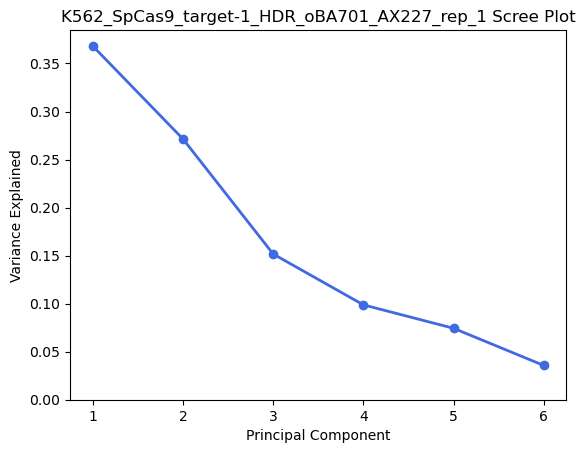

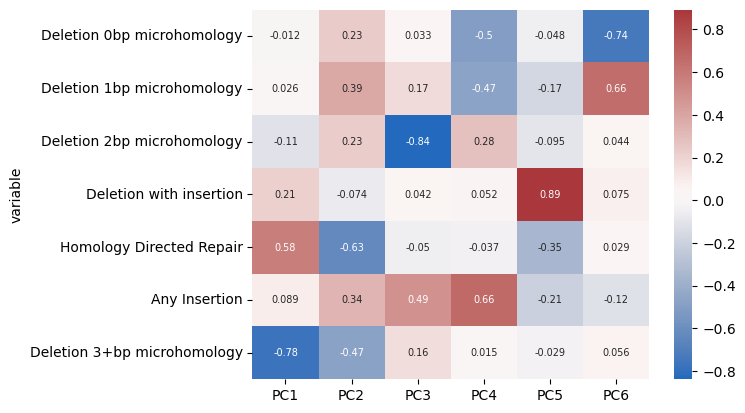

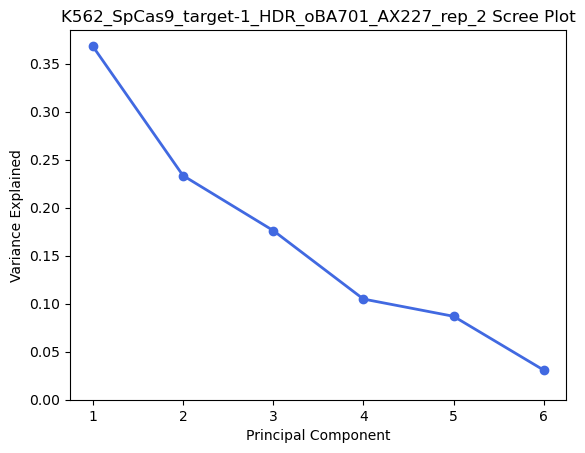

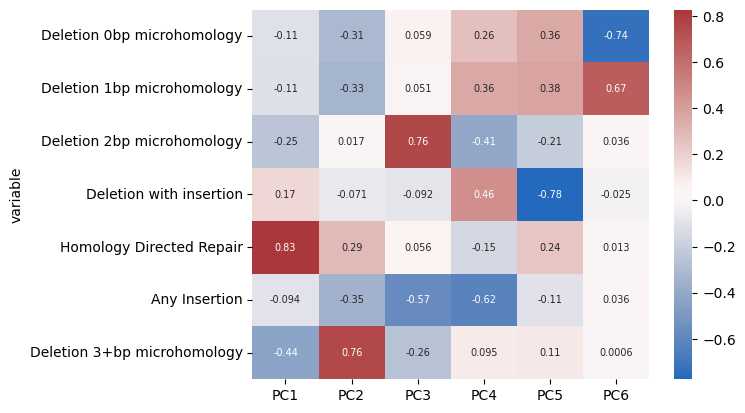

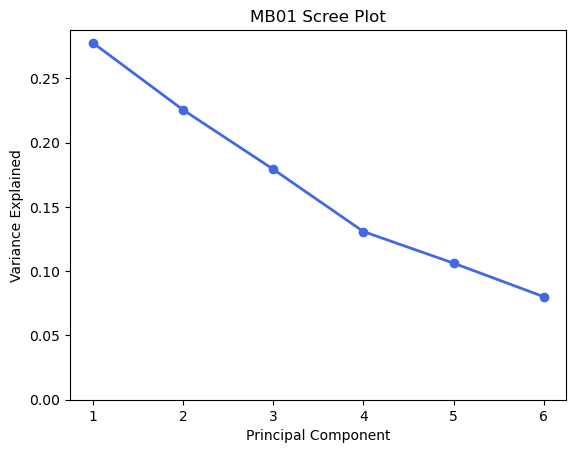

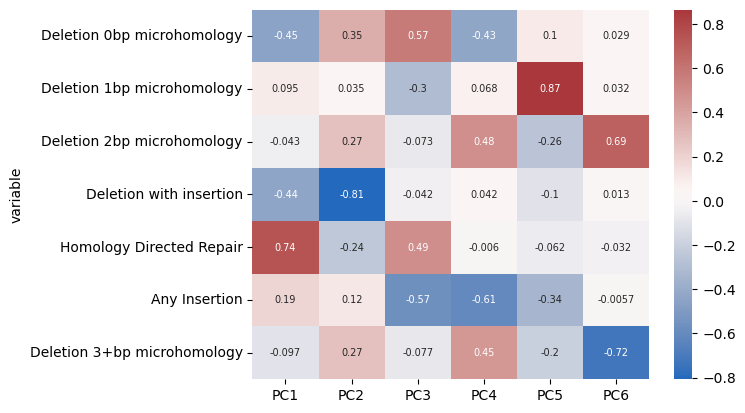

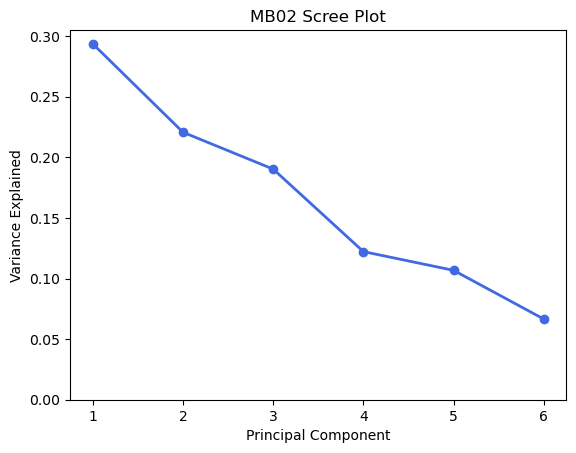

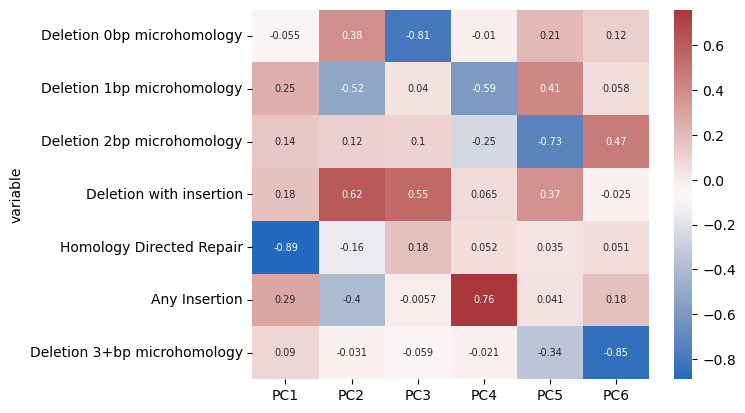

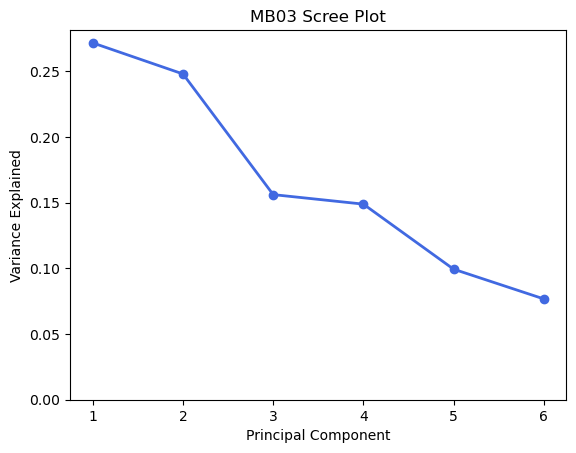

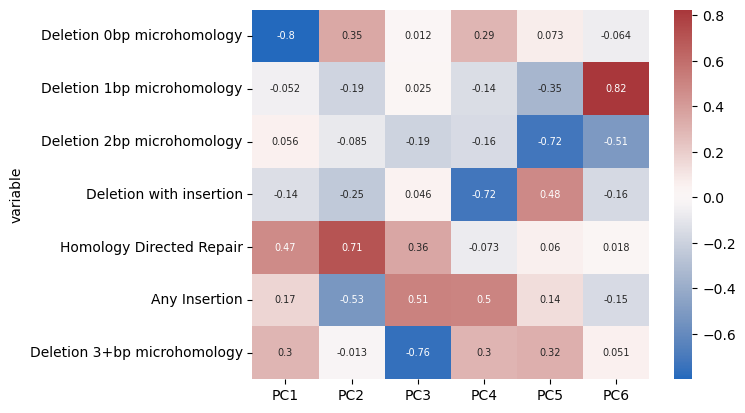

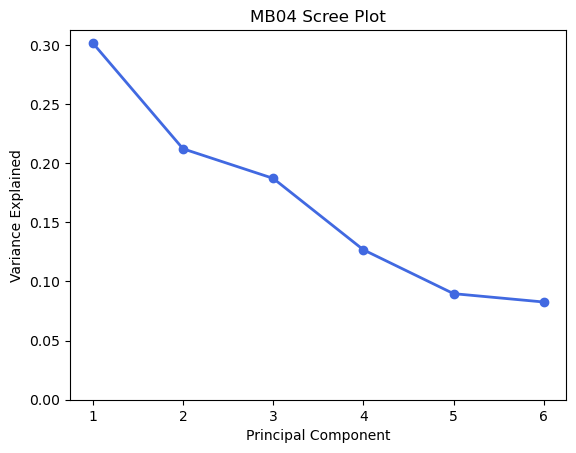

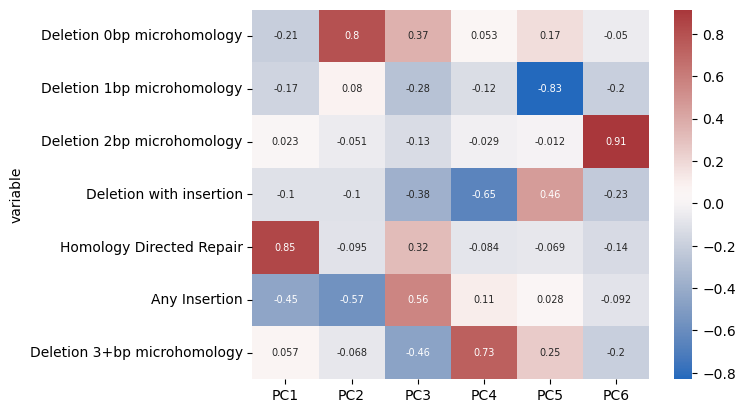

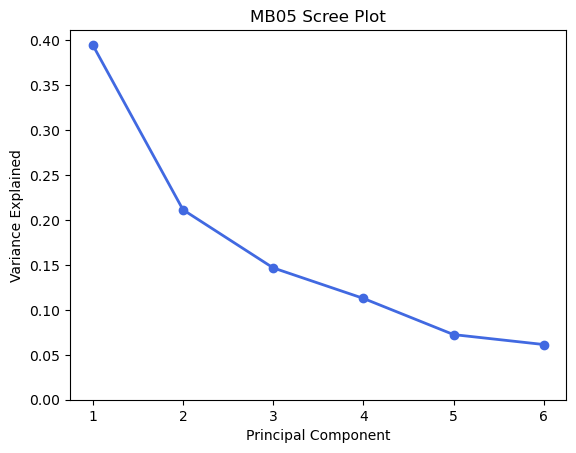

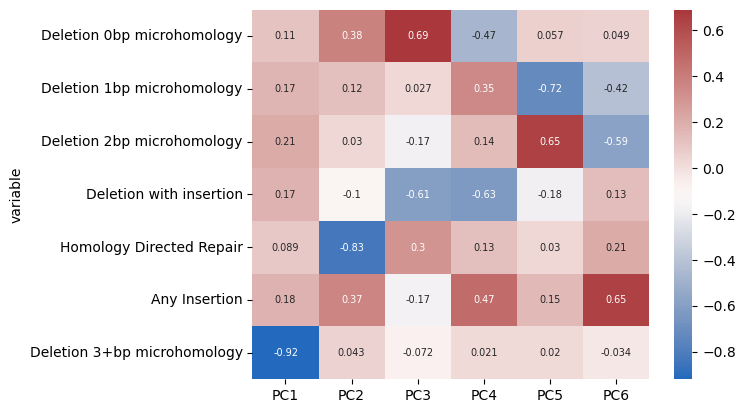

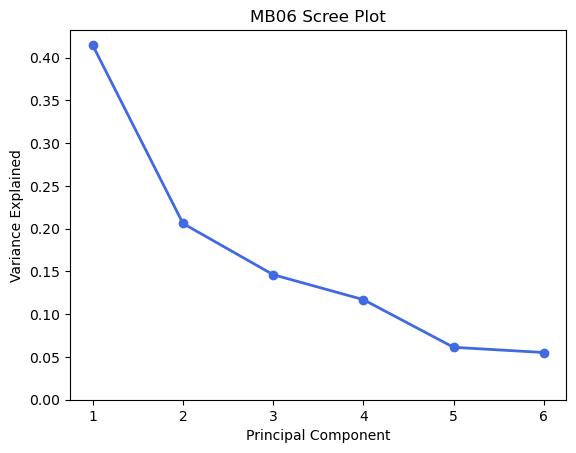

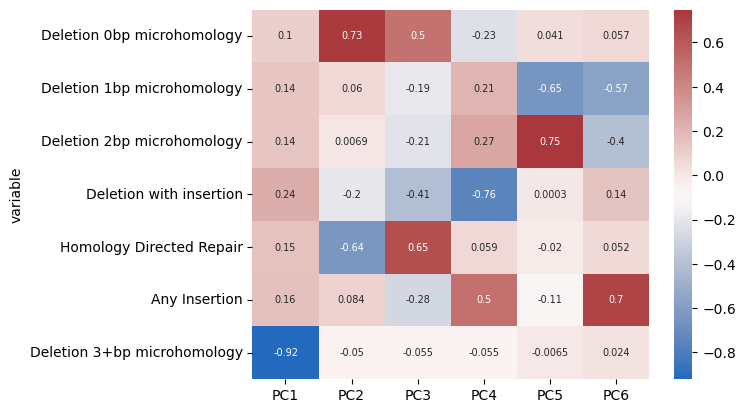

In [11]:
results = {}
for alias in Z.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(Z[alias].loc[common_genes], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.savefig("{}/screeplot.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    plt.show()

    loadings_df, z = loadingsplot(loadings, Z[alias].loc[common_genes].columns.to_list())
    plt.savefig("{}/laodingsplot.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    plt.show()

    #Call the function. Use only the 2 PCs.
    # pcs_to_analyse = [0,1]
    # biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse], components=loadings_df.iloc[:,pcs_to_analyse].columns)
    # plt.savefig("{}/biplot.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    # plt.show()

In [12]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[alias][-1],
"distances": results[alias][-2]}, index=Z[alias].loc[common_genes].index) for alias in sorted(Z.keys())]

# FDR correction, removed Thu 16 Feb. Can be applied later to the orignal p-Consistencys, do not rerun this code to get FDR correction. Only use final_gene_list.tsv spreadsheet
# for pConsistency_df in pvalue_dfs:
#     corrected = fdrcorrection(pConsistency_df["pvalues"], alpha=FDR_ALPHA)
#     pConsistency_df["reject"] = corrected[0]
#     pConsistency_df["pvals_corrected"] = corrected[1]

results_df = pd.concat(pvalue_dfs, axis=1, keys=sorted(Z.keys()))
results_df.columns.names = ["Sample", "Measure"]
print(results_df.shape)
results_df.head()

(322, 16)


Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1             \
Measure                                     pvalues  distances   
Gene                                                             
Actr5                                  1.350300e-10  54.928548   
Actr8                                  1.049611e-02  14.968886   
Aicda                                  5.619932e-01   3.913107   
Alkbh2                                 9.002526e-01   1.608227   
Alyref                                 5.639852e-04  21.830160   

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2                 MB01  \
Measure                                     pvalues  distances   pvalues   
Gene                                                                       
Actr5                                      0.000021  29.248971  0.626757   
Actr8                                      0.010304  15.013677  0.032082   
Aicda                                      0.910815   1.519446  0.508604   
Alkbh2                                     0.624598   3.492003  0.262313   
Alyref                                     0.000035  28.067341  0.017271   

Sample                  MB02                 MB03                MB04  \
Measure  distances   pvalues  distances   pvalues distances   pvalues   
Gene                                                                    
Actr5     3.477751  0.334904   5.715395  0.407359  5.070316  0.986848   
Actr8    12.205197  0.037486  11.809992  0.421253  4.956168  0.464511   
Aicda     4.288972  0.766479   2.566300  0.358006  5.499448  0.014131   
Alkbh2    6.479526  0.136390   8.382239  0.844005  2.036980  0.916303   
Alyref   13.750943  0.069861  10.196262  0.148943  8.135139  0.041657   

Sample                  MB05                 MB06             
Measure  distances   pvalues  distances   pvalues  distances  
Gene                                                          
Actr5     0.624629  0.377684   5.323538  0.719261   2.874931  
Actr8     4.616028  0.679784   3.131087  0.109040   9.000604  
Aicda    14.244065  0.653569   3.301784  0.013094  14.430490  
Alkbh2    1.471784  0.850931   1.987073  0.104935   9.105345  
Alyref   11.540461  0.062192  10.502254  0.011873  14.669372

In [13]:
score_df = results_df.dropna()
score_df = pd.DataFrame(StandardScaler().fit_transform(score_df.xs("distances", level="Measure", axis=1)), columns=score_df.columns.unique(level=0), index=score_df.index)
score_df.loc[:,"Max Score"] = score_df.max(axis=1)
score_df.loc[:,"Mean Score"] = score_df.mean(axis=1)
score_df.head()

Sample,K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1,K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2,MB01,MB02,MB03,MB04,MB05,MB06,Max Score,Mean Score
Gene,,,,,,,,,,
Actr5,-0.084156,-0.173596,-0.558796,-0.388097,-0.348172,-0.674549,-0.410233,-0.517229,-0.084156,-0.359887
Actr8,-0.180458,-0.241916,0.088715,0.031929,-0.355229,-0.396157,-0.600582,-0.054809,0.088715,-0.179977
Aicda,-0.207102,-0.306678,-0.498609,-0.605126,-0.321644,0.275377,-0.585762,0.355087,0.355087,-0.171041
Alkbh2,-0.212657,-0.297212,-0.336087,-0.204304,-0.535689,-0.615461,-0.699906,-0.046902,-0.046902,-0.332791
Alyref,-0.163922,-0.179267,0.203397,-0.079286,-0.158709,0.086806,0.039384,0.373120,0.373120,0.054960


In [15]:
psuedo_controls = score_df.dropna().sort_values("Mean Score").iloc[:30,0].index.to_list()
print(psuedo_controls[:5])

['Eme1', 'Phc1', 'Kdm4a', 'Chd5', 'Ddx58']


In [17]:
df = pd.concat(Z.values(), keys=sorted(Z.keys()), names=["Sample"])
print(df.shape)

psudo_control_df = df.loc[df.index.get_level_values("Gene").isin(psuedo_controls), :]
psudo_control_gmean_df = pd.DataFrame(psudo_control_df.groupby("Sample")
                                      .apply(stats.gmean).values.tolist(), index=Z.keys(), columns=df.columns)
psudo_control_gmean_df.index.name="Sample"
psudo_control_gmean_df

psudo_control_gmean_df = psudo_control_gmean_df.div(psudo_control_gmean_df.sum(axis=1), axis=0)

print(psudo_control_gmean_df.shape)

change_df = df - psudo_control_gmean_df
change_df
print(change_df.shape)


(105792, 7)
(8, 7)
(105792, 7)


In [18]:
sorted(Z.keys())

['K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1',
 'K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2',
 'MB01',
 'MB02',
 'MB03',
 'MB04',
 'MB05',
 'MB06']

In [19]:
def consistency(x, change_df, sample1, sample2):
    if (sample1, x) not in change_df.index:
        return np.nan

    if (sample2, x) not in change_df.index:
        return np.nan

    return stats.spearmanr(change_df.loc[(sample1, x),:].dropna(), change_df.loc[(sample2, x),:].dropna())[0]

results_df.loc[:,("T1", "Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, change_df, "MB01", "MB02"))
results_df.loc[:,("T2", "Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, change_df, "MB03", "MB04"))
results_df.loc[:,("T3", "Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, change_df, "MB05", "MB06"))
results_df.loc[:,("Adamson_T1", "Consistency")] = results_df.index.to_series()\
    .apply(lambda x: consistency(x, change_df, \
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))

In [20]:
results_df

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1              \
Measure                                     pvalues   distances   
Gene                                                              
Actr5                                  1.350300e-10   54.928548   
Actr8                                  1.049611e-02   14.968886   
Aicda                                  5.619932e-01    3.913107   
Alkbh2                                 9.002526e-01    1.608227   
Alyref                                 5.639852e-04   21.830160   
...                                             ...         ...   
Xrcc4                                  3.046627e-01    6.016025   
Xrcc6                                  0.000000e+00  191.292759   
Ybx3                                   6.614619e-02   10.340356   
Yy1                                    6.443704e-01    3.361956   
Zranb3                                 6.000318e-01    3.655287   

Sample  K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2                  MB01  \
Measure                                     pvalues   distances   pvalues   
Gene                                                                        
Actr5                                      0.000021   29.248971  0.626757   
Actr8                                      0.010304   15.013677  0.032082   
Aicda                                      0.910815    1.519446  0.508604   
Alkbh2                                     0.624598    3.492003  0.262313   
Alyref                                     0.000035   28.067341  0.017271   
...                                             ...         ...       ...   
Xrcc4                                      0.766580    2.565633  0.000010   
Xrcc6                                      0.000000  125.919826  0.000008   
Ybx3                                       0.116038    8.830048  0.040729   
Yy1                                        0.827233    2.155532  0.797248   
Zranb3                                     0.828048    2.149837  0.703749   

Sample                      MB02                 MB03             \
Measure  distances       pvalues  distances   pvalues  distances   
Gene                                                               
Actr5     3.477751  3.349044e-01   5.715395  0.407359   5.070316   
Actr8    12.205197  3.748616e-02  11.809992  0.421253   4.956168   
Aicda     4.288972  7.664787e-01   2.566300  0.358006   5.499448   
Alkbh2    6.479526  1.363900e-01   8.382239  0.844005   2.036980   
Alyref   13.750943  6.986145e-02  10.196262  0.148943   8.135139   
...            ...           ...        ...       ...        ...   
Xrcc4    30.907972  2.206592e-02  13.144016  0.000091  25.961844   
Xrcc6    31.386282  6.377201e-08  41.829560  0.000000  94.242524   
Ybx3     11.598117  4.770203e-01   4.521438  0.333473   5.729146   
Yy1       2.361131  3.337153e-01   5.726811  0.229991   6.876465   
Zranb3    2.975592  1.626201e-01   7.886197  0.091893   9.465015   

Sample           MB04                 MB05                 MB06              \
Measure       pvalues  distances   pvalues  distances   pvalues   distances   
Gene                                                                          
Actr5    9.868479e-01   0.624629  0.377684   5.323538  0.719261    2.874931   
Actr8    4.645109e-01   4.616028  0.679784   3.131087  0.109040    9.000604   
Aicda    1.413120e-02  14.244065  0.653569   3.301784  0.013094   14.430490   
Alkbh2   9.163028e-01   1.471784  0.850931   1.987073  0.104935    9.105345   
Alyref   4.165695e-02  11.540461  0.062192  10.502254  0.011873   14.669372   
...               ...        ...       ...        ...       ...         ...   
Xrcc4    3.376515e-01   5.689137  0.000139  25.010084  0.000821   20.969087   
Xrcc6    2.997602e-15  77.368487  0.000000  90.383457  0.000000  162.692895   
Ybx3     6.051893e-01   3.620825  0.896692   1.637383  0.723491    2.847446   
Yy1      7.062427e-01   2.959417  0.422963   4.942294  0.506073    4.307297   
Zr

In [21]:
outlier_details_df = pd.read_pickle(get_experiment_artifacts(profile_type=SAMPLE, method="robust_cov", filter_count=700) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik  0.340629        -0.250000  -0.420581                -0.362677   
0610010K14Rik -0.339087         0.464286  -0.593305                -0.183878   
0610030E20Rik -0.012887         0.035714  -0.334304                 0.194480   
0610040J01Rik  1.405359         0.107143   0.386962                -0.246977   
1110004F10Rik  1.223375        -0.178571   0.208164                -0.115229   
...                 ...              ...        ...                      ...   
Znhit1         0.550000         0.160714   0.225832                 0.962391   
Zranb2         1.278388         0.071429   0.495311                 0.745030   
Zrsr1          1.347381        -0.125000   0.240567                -1.200930   
Zup1           0.948928        -0.142857   0.206600                -0.312950   
Zwilch         1.850794         0.125000   0.324977                -0.603581   

Sample                                MB01                        MB02  \
Measure       Mean Std Consistency  Counts distances   pvalues  Counts   
Gene                                                                     
0610009B22Rik            -0.875111  2792.0  2.208519  0.819605  3122.0   
0610010K14Rik             0.856053  2320.5  1.027360  0.960329  2451.0   
0610030E20Rik            -0.151019  1638.0  9.058759  0.106743  2770.0   
0610040J01Rik             0.003445  1753.0  8.903629  0.112970  1798.0   
1110004F10Rik            -0.669054  1876.0  9.464008  0.091927  1929.0   
...                            ...     ...       ...       ...     ...   
Znhit1                    0.149099  1347.0       NaN       NaN     NaN   
Zranb2                   -0.070255     NaN       NaN       NaN  1180.0   
Zrsr1                    -0.521981     NaN       NaN       NaN  1339.5   
Zup1                     -0.567696  1292.5       NaN       NaN     NaN   
Zwilch                    0.059764     NaN       NaN       NaN     NaN   

Sample                    ...          T1              T2              \
Measure        distances  ... Consistency CLR Consistency Consistency   
Gene                      ...                                           
0610009B22Rik   2.124921  ...   -0.821429        0.392857    0.500000   
0610010K14Rik   0.854783  ...    0.678571       -0.321429    0.071429   
0610030E20Rik   4.471164  ...    0.464286        0.214286    0.071429   
0610040J01Rik  16.242836  ...    0.250000       -0.321429   -0.071429   
1110004F10Rik  17.195650  ...    0.107143       -0.071429   -0.214286   
...                  ...  ...         ...             ...         ...   
Znhit1               NaN  ...         NaN        0.714286    0.821429   
Zranb2               NaN  ...         NaN        0.321429   -0.178571   
Zrsr1                NaN  ...         NaN       -0.428571    0.250000   
Zup1                 NaN  ...         NaN       -0.107143   -0.107143   
Zwilch               NaN  ...         NaN        0.071429    0.285714   

Sample                     T3             Gene Sets              \
Measure       CLR Consistency Consistency   Adamson GeneSubset2   
Gene                                                              
0610009B22Rik        0.250000   -0.428571     False       False   
0610010K14Rik       -0.357143    0.642857     False       False   
0610030E20Rik        0.000000   -0.428571     False       False   
0610040J01Rik        0.285714    0.142857     False       False   
1110004F10Rik       -0.142857   -0.428571     False       False   
...                       ...         ...       ...         ...   
Znhit1               0.250000   -0.500000      True       False   
Zranb2               0.464286    0.321429     False       False   
Zrsr1               -0.428571   -0.500000     False       False   
Zup1           

<AxesSubplot: xlabel='Consistency', ylabel='Sample'>

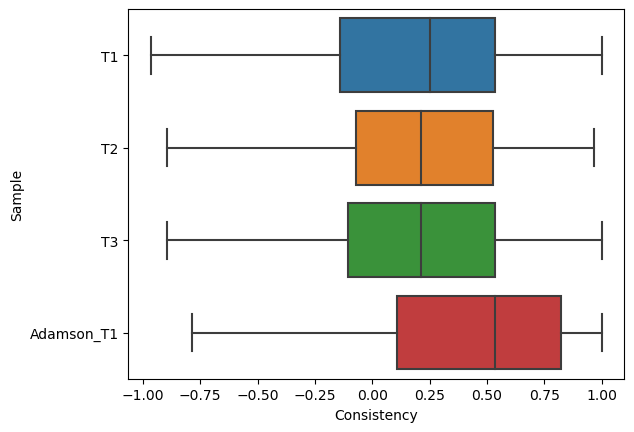

In [30]:
consistency_df = results_df.xs("Consistency", level="Measure", axis=1).dropna().stack().reset_index().rename(columns={0: "Consistency"})
sns.boxplot(data=consistency_df, x="Consistency", y="Sample")

<AxesSubplot:xlabel='Consistency', ylabel='Sample'>

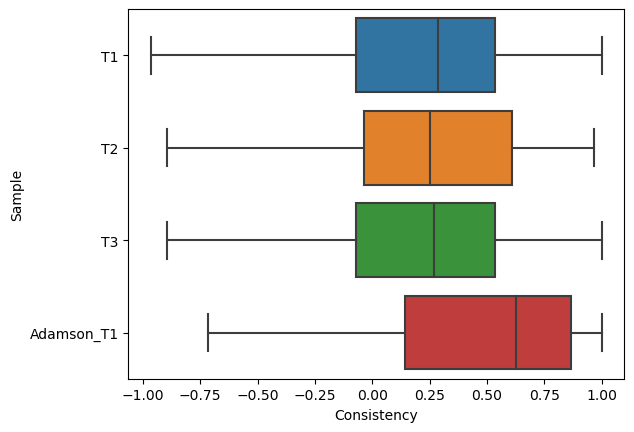

In [113]:
goDSBgenes = outlier_details_df.xs("isGODSBRepair", level="Measure", axis=1)["Global"]
goDSBgenes = goDSBgenes[goDSBgenes].index.to_list()
sns.boxplot(data=consistency_df[consistency_df.Gene.isin(goDSBgenes)], x="Consistency", y="Sample")

<AxesSubplot:xlabel='Consistency', ylabel='Sample'>

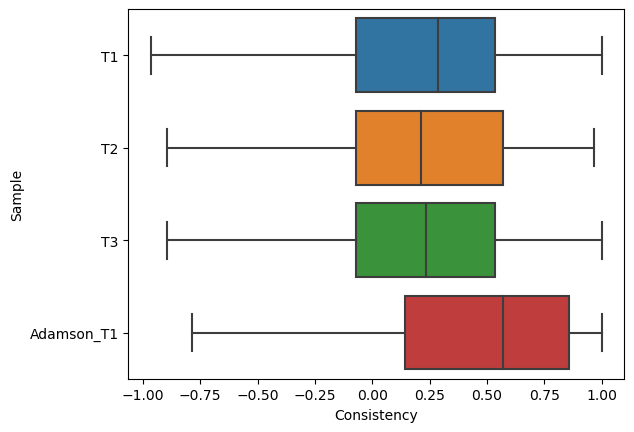

In [114]:
goDSBgenes = outlier_details_df.xs("isGORepair", level="Measure", axis=1)["Global"]
goDSBgenes = goDSBgenes[goDSBgenes].index.to_list()
sns.boxplot(data=consistency_df[consistency_df.Gene.isin(goDSBgenes)], x="Consistency", y="Sample")

This shows that the issue of consistency isn't just in our data, it is in the Adamson dataset too.

# Breakdown of consistency by molecular function

In [133]:
X = results_df.xs("Consistency", level="Measure", axis=1) 
X.head()

Sample,T1,T2,T3,Adamson_T1
Gene,,,,
Actr5,0.535714,0.107143,0.750000,0.857143
Actr8,0.321429,0.785714,0.000000,0.785714
Aicda,-0.535714,-0.142857,-0.821429,0.285714
Alkbh2,-0.535714,0.035714,-0.035714,0.321429
Alyref,-0.321429,0.642857,0.500000,0.107143


In [221]:
BP = pd.read_pickle("artifacts/adamson_BP_terms.pkl")
X_bp = X.join(BP.T, how="inner")
X_bp.head()
print(X_bp.shape)


MF = pd.read_pickle("artifacts/adamson_MF_terms.pkl")
X_mf = X.join(MF.T, how="inner")
X_mf.head()

print(X_mf.shape)

common_genes = np.intersect1d(X_mf.index, X_bp.index)
X_mf = X_mf.loc[common_genes]
X_bp = X_bp.loc[common_genes]

print(X_bp.shape)
print(X_mf.shape)

(312, 322)
(295, 183)
(289, 322)
(289, 183)


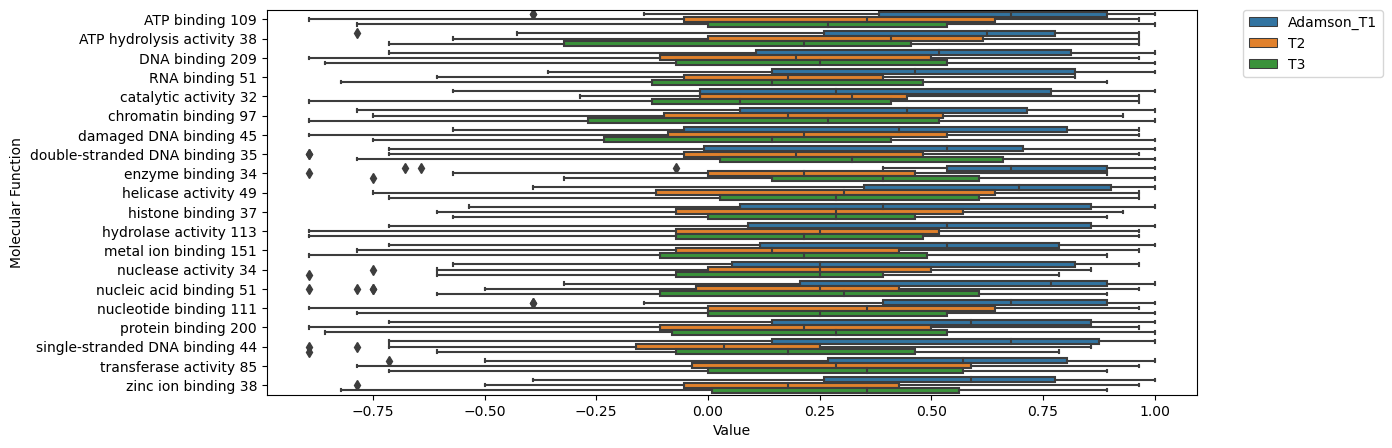

In [247]:
plot_df = X_mf[["Adamson_T1", "T2", "T3"]].stack()
plot_dfs = []

top_mf = MF.sum(axis=1).sort_Consistencys(ascending=False)
top_mf = top_mf.iloc[top_mf.index.argsort()]
top_mf = top_mf[top_mf > 30]

for mf in top_mf.index.to_list():
    genes_to_plot = X_mf.loc[X_mf[mf].astype(bool)].index.to_list()
    if len(genes_to_plot) == 0:
        continue

    p = plot_df[genes_to_plot].reset_index().rename(columns={"level_0": "Gene", "level_1": "Target", 0: "Consistency"})
    p["Molecular Function"] = mf
    plot_dfs.append(p)

plot_df = pd.concat(plot_dfs, axis=0)
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data = plot_df.sort_Consistencys("Molecular Function"), x = "Consistency", y = "Molecular Function", hue="Target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_yticklabels(top_mf.index.to_series().str.cat(top_mf.Consistencys.astype(str), sep=" "))
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


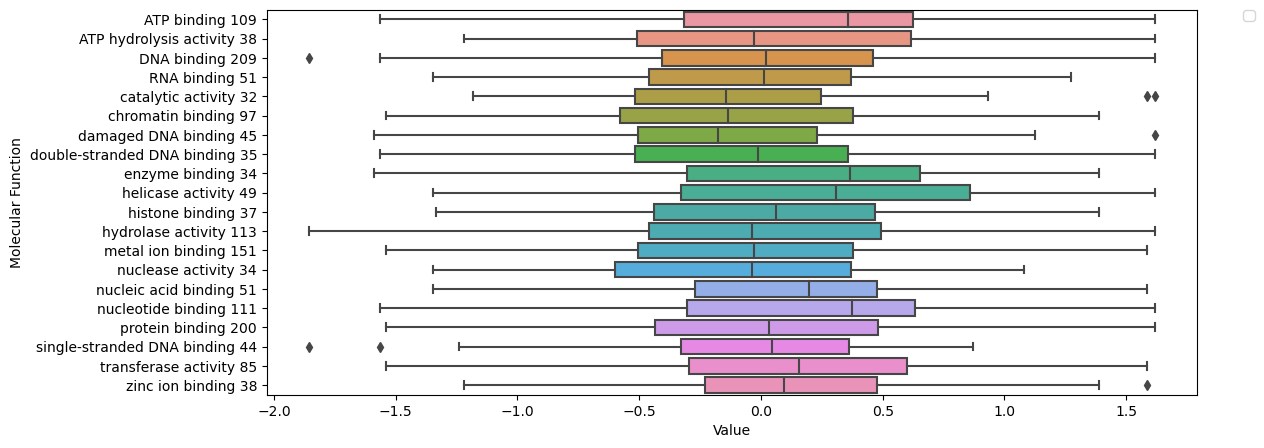

In [290]:
plot_df = pd.DataFrame(StandardScaler().fit_transform(X_mf[["Adamson_T1", "T2", "T3"]]), columns=["Adamson_T1", "T2", "T3"], index=X_mf.index)\
    .mean(axis=1).reset_index().rename(columns={"index": "Gene", 0: "Consistency"}).set_index("Gene")
plot_dfs = []

top_mf = MF.sum(axis=1).sort_Consistencys(ascending=False)
top_mf = top_mf.iloc[top_mf.index.argsort()]
top_mf = top_mf[top_mf > 30]

for mf in top_mf.index.to_list():
    genes_to_plot = X_mf.loc[X_mf[mf].astype(bool)].index.to_list()
    if len(genes_to_plot) == 0:
        continue

    p = plot_df.loc[genes_to_plot].reset_index().rename(columns={"level_0": "Gene", 0: "Consistency"})
    p["Molecular Function"] = mf
    plot_dfs.append(p)

plot_df = pd.concat(plot_dfs, axis=0)
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data = plot_df, x = "Consistency", y = "Molecular Function")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_yticklabels(top_mf.index.to_series().str.cat(top_mf.Consistencys.astype(str), sep=" "))
plt.show()

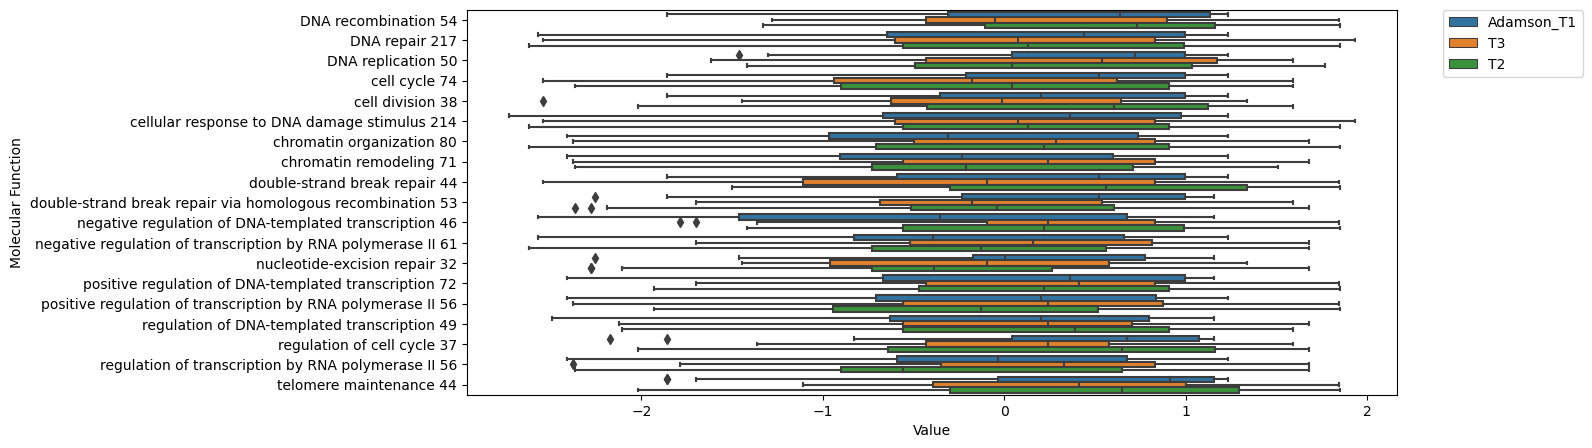

In [271]:
plot_df = pd.DataFrame(StandardScaler().fit_transform(X_bp[["Adamson_T1", "T2", "T3"]]), columns=["Adamson_T1", "T2", "T3"], index=X_bp.index).stack()
plot_dfs = []

top_bp = BP.sum(axis=1).sort_Consistencys(ascending=False)
top_bp = top_bp.iloc[top_bp.index.argsort()]
top_bp = top_bp[top_bp > 30]

for bp in top_bp.index.to_list():
    genes_to_plot = X_bp.loc[X_bp[bp].astype(bool)].index.to_list()
    if len(genes_to_plot) == 0:
        continue

    p = plot_df[genes_to_plot].reset_index().rename(columns={"level_0": "Gene", "level_1": "Target", 0: "Consistency"})
    p["Molecular Function"] = bp
    plot_dfs.append(p)

plot_df = pd.concat(plot_dfs, axis=0)
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data = plot_df.sort_Consistencys("Molecular Function"), x = "Consistency", y = "Molecular Function", hue="Target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_yticklabels(top_bp.index.to_series().str.cat(top_bp.Consistencys.astype(str), sep=" "))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


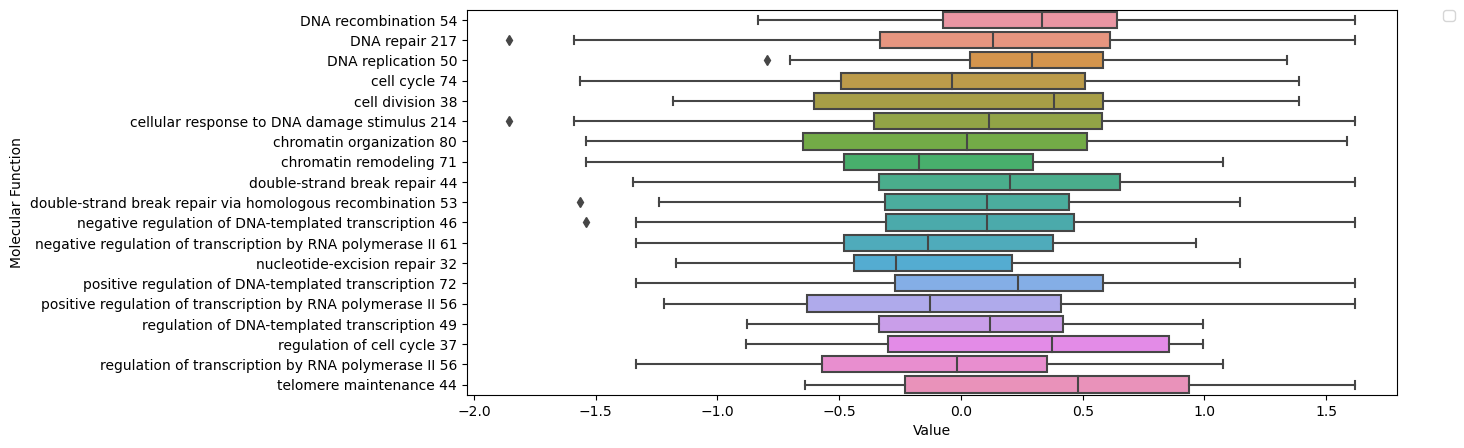

In [289]:
plot_df = pd.DataFrame(StandardScaler().fit_transform(X_bp[["Adamson_T1", "T2", "T3"]]), columns=["Adamson_T1", "T2", "T3"], index=X_bp.index)\
    .mean(axis=1).reset_index().rename(columns={"index": "Gene", 0: "Consistency"}).set_index("Gene")
plot_dfs = []

top_bp = BP.sum(axis=1).sort_Consistencys(ascending=False)
top_bp = top_bp.iloc[top_bp.index.argsort()]
top_bp = top_bp[top_bp > 30]

for bp in top_bp.index.to_list():
    genes_to_plot = X_bp.loc[X_bp[bp].astype(bool)].index.to_list()
    if len(genes_to_plot) == 0:
        continue

    p = plot_df.loc[genes_to_plot].reset_index().rename(columns={"level_0": "Gene", 0: "Consistency"})
    p["Molecular Function"] = bp
    plot_dfs.append(p)

plot_df = pd.concat(plot_dfs, axis=0)
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data = plot_df, x = "Consistency", y = "Molecular Function")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_yticklabels(top_bp.index.to_series().str.cat(top_bp.Consistencys.astype(str), sep=" "))
plt.show()